# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [18]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=50):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [30]:
# plot results of multi step forcasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=50):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [31]:
# plot results of multi step forcasting
# plot result of multi step forcasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=50):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

You can use split_input_df to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [7]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, val_split_ratio=0.1, test_split_ratio=0.1)

In [8]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [9]:
train_df.head(5)

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [10]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


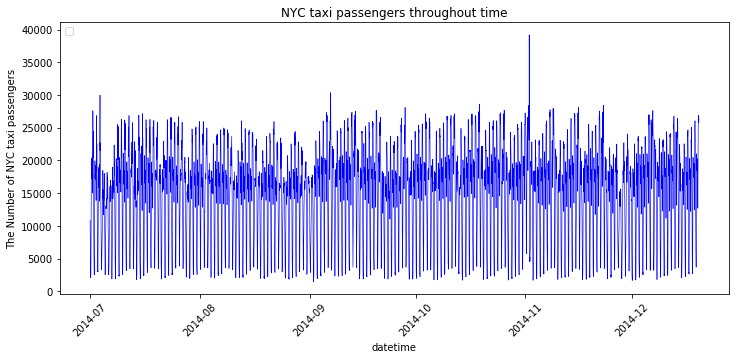

In [11]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. Currently, our automl support searching feature combinations in a predefined feature space, and searching model hyper-parameters. Model selection is not supported yet.  

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value'\].  

We use a vanilla LSTM model to predict time series data. The model search space contains the unit num of lstm layers ,dropout rate and hyper-parameters for training, such as batch_size, learning rate, etc. 

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`. The previous sequence length will be  considered as a tunable variable in our future version.

In [12]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

Using TensorFlow backend.


In [13]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default trail num is 10, need about 5.5 mins.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mean_squared_error")
print("Training completed.")

2019-06-09 00:06:18,130	INFO node.py:497 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-06-09_00-06-18_129838_28590/logs.
2019-06-09 00:06:18,239	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:32687 to respond...
2019-06-09 00:06:18,370	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:11429 to respond...
2019-06-09 00:06:18,374	INFO services.py:806 -- Starting Redis shard with 10.0 GB max memory.
2019-06-09 00:06:18,406	INFO node.py:511 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-06-09_00-06-18_129838_28590/logs.
2019-06-09 00:06:18,408	WARNING services.py:1293 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2019-06-09 00:06:18,408	INFO services.py:1441 -- Starting the Plasma object store with 20.0 GB memory using /dev/shm.
2019-06-09 00:06:18,692	INFO tune.py:60 -- Tip: to resume incomplete experiments, pa

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 19.2/67.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs
Memory usage on this node: 19.2/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_func_1_dropout_2=0.33716,lstm_1_units=32,selected_features=['WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_2=0.31916,lstm_1_units=16,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime)']:	RUNNING

(pid=28639) Using TensorFlow backend.
(pid=28641) Using TensorFlow backend.
(pid=28638) Using TensorFlow backend.
(pid=28640) Using TensorFlow backend.
(pid=28637) Using TensorFlow backend.
(pid=28636) Using TensorFlow backend.
(pid=28706) Using TensorFlow backend.
(pid=28703) Using TensorFlow backend.
(pid

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.5/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.31916,lstm_1_units=16,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=28637], 193 s, 7 iter
 - train_func_1_dropout_2=0.33716,lstm_1_units=32,selected_features=['WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=28639], 218 s, 6 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.5/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.31916,lstm_1_units=16,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime

2019-06-09 00:11:45,729	INFO ray_trial_executor.py:180 -- Destroying actor for trial train_func_1_dropout_2=0.33716,lstm_1_units=32,selected_features=['WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.4/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.31916,lstm_1_units=16,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_WEEKEND(datetime)'
 'IS_AWAKE(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=28637], 272 s, 10 iter
 - train_func_1_dropout_2=0.33716,lstm_1_units=32,selected_features=['WEEKDAY(datetime)' 'IS_BUSY_HOURS(datetime)' 'IS_WEEKEND(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=28639], 324 s, 10 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.4/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.31916,lstm_1_units=16,selected_features=['MONTH(datetime)' 'DAY(datetime)' 'IS_WEEKEND(datetime)'

## 3. Test

In [14]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [15]:
pred_df.head(5)

,datetime,value
0,2015-01-11 13:00:00,20405.748047
1,2015-01-11 13:30:00,20673.132812
2,2015-01-11 14:00:00,20313.445312
3,2015-01-11 14:30:00,19685.296875
4,2015-01-11 15:00:00,19445.414062


In [16]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


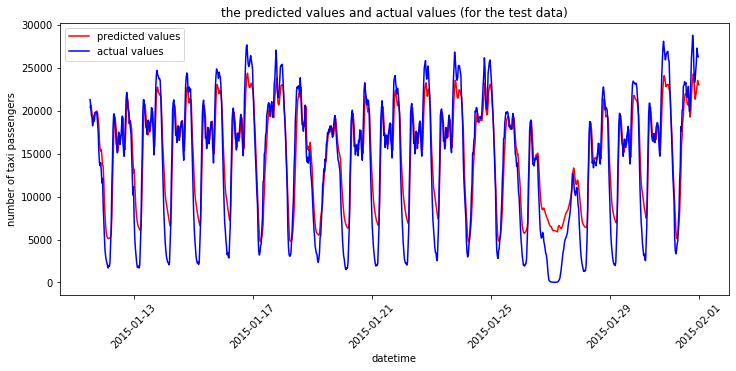

In [19]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

In [20]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metric=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is [8075045.80262568]
Evaluate: the r_squared value is [0.85483533]


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [23]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


In [24]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

Restore pipeline from /tmp/saved_pipeline/my.ppl


In [25]:
# you can do predict and evaluate again
# to compare results before and after restore, we use test_df as input
new_pred = new_pipeline.predict(test_df)

In [26]:
new_pred.head(5)

,datetime,value
0,2015-01-11 13:00:00,20405.748047
1,2015-01-11 13:30:00,20673.132812
2,2015-01-11 14:00:00,20313.445312
3,2015-01-11 14:30:00,19685.296875
4,2015-01-11 15:00:00,19445.414062


In [27]:
# evaluate test_df
mse, rs = new_pipeline.evaluate(test_df, metric=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_square value is", rs)

Evaluate: the mean square error is [8075045.80262568]
Evaluate: the r_square value is [0.85483533]


## 5. multi step forcasting 

You can do multi step forcasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [28]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [29]:
# train
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mean_squared_error")
print("Training completed.")

2019-06-09 00:14:46,263	ERROR worker.py:1347 -- Calling ray.init() again after it has already been called.
2019-06-09 00:14:46,271	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-06-09 00:14:46,272	INFO tune.py:223 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.1/67.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.1/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_func_1_dropout_2=0.27841,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_2=0.23915,lstm_1_units=16,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'HOUR(datetime)' 'WEEKDAY(datetime)']:	RUNNING

(pid=28706) 2019-06-09 00:14:50.428601: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=28640) 2019-06-09 00:14:50.489119: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports ins

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.3/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.23915,lstm_1_units=16,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'HOUR(datetime)' 'WEEKDAY(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=28706], 258 s, 9 iter
 - train_func_1_dropout_2=0.27841,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=28640], 229 s, 6 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.3/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.23915,lstm_1_units=16,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'HOUR(datetime)' 'WEEKDAY(datetime

2019-06-09 00:20:38,144	INFO ray_trial_executor.py:180 -- Destroying actor for trial train_func_1_dropout_2=0.27841,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.3/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.23915,lstm_1_units=16,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'HOUR(datetime)' 'WEEKDAY(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=28706], 284 s, 10 iter
 - train_func_1_dropout_2=0.27841,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'HOUR(datetime)' 'IS_BUSY_HOURS(datetime)'
 'MONTH(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=28640], 351 s, 10 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 20.3/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.23915,lstm_1_units=16,selected_features=['DAY(datetime)' 'MONTH(datetime)' 'HOUR(datetime

In [32]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [33]:
pred_df.head(5)

,datetime,value_0,value_1,value_2,value_3,value_4
0,2015-01-11 13:00:00,19621.044922,19514.408203,19265.568359,18862.519531,18364.560547
1,2015-01-11 13:30:00,19963.865234,19764.708984,19400.628906,18879.458984,18266.921875
2,2015-01-11 14:00:00,20156.365234,19864.681641,19393.789062,18769.828125,18064.917969
3,2015-01-11 14:30:00,20186.689453,19809.611328,19247.375000,18542.191406,17771.962891
4,2015-01-11 15:00:00,20072.792969,19615.302734,18974.634766,18207.310547,17396.302734


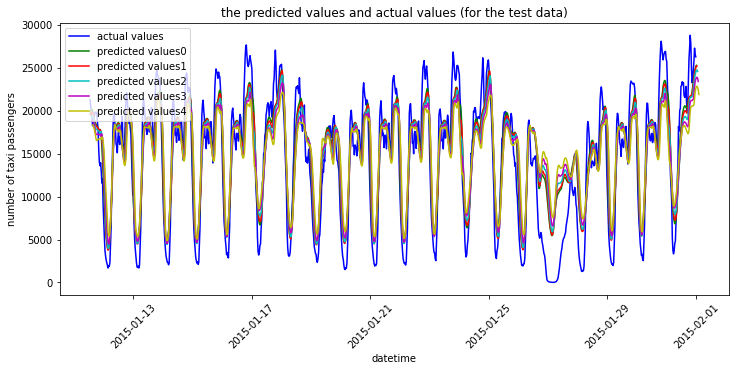

In [34]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df)

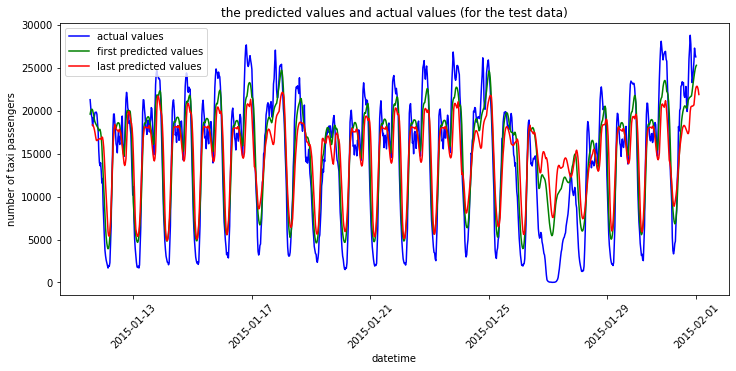

In [35]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df)

In [36]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metric=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is [ 9174002.64231619 11177002.84882396 13810776.62380472 16823597.79171204
 20250512.87206157]
Evaluate: the r_squared value is [0.83397641 0.79802948 0.75103922 0.6974119  0.636565  ]
